# **Comprehensive LISS-III Analysis and Hierarchical Classification Jupyter Notebook**

```yaml
---
title: "Advanced Processing and Classification of LISS-III Imagery"
author: "Vaibhav Bansal"
date: "January 2025"
language: "en"
format: "jupyter"
---
```

> **Note**  
> This notebook provides a **full-length**, self-contained workflow for **LISS-III** data:
> 1. **Pre-processing**: Outlier removal, noise reduction (median + FFT-based destriping), and band enhancement (linear stretch + CLAHE).  
> 2. **Feature Detection & Matching**: SIFT feature extraction, FLANN matching, and homography-based transformations for mosaicking.  
> 3. **Hierarchical LULC Classification** (Level 1, Level 2, Level 3):  
>    - Collecting training samples from user-provided polygons.  
>    - Random Forest classification.  
>    - Evaluating accuracy via a confusion matrix.  

This notebook focuses **exclusively** on **LISS-III** imagery.

---

## **Table of Contents**

1. [Introduction](#introduction)  
2. [Dataset and Workflow Overview](#dataset-overview)  
3. [Environment Setup](#env-setup)  
4. [LISS3Processor Class](#liss3processor)  
   1. [Outlier Removal](#outlier-removal)  
   2. [Noise Reduction](#noise-reduction)  
   3. [Enhancement](#enhancement)  
   4. [Feature Detection & Matching](#feature-detection)  
   5. [Transformation & Mosaic](#mosaic)  
5. [Helper Visualization Functions](#helper-visuals)  
6. [LISS3Classifier Class](#liss3classifier)  
   1. [Masks from Shapefile or Indices](#masks)  
   2. [Collect Training Samples](#collect-samples)  
   3. [Train RandomForest Classifier](#train-classifier)  
   4. [Hierarchical Classification (L1, L2, L3)](#hier-classification)  
   5. [Accuracy Evaluation](#accuracy)  
7. [Sample Usage](#sample-usage)  
8. [Conclusion](#conclusion)

---

## **1. Introduction** <a id="introduction"></a>
India’s Remote Sensing satellite (IRS) LISS-III sensor captures multi-spectral images in **Green, Red, NIR, and SWIR** bands (though SWIR availability may depend on specific LISS-III generation). This notebook provides a robust approach to:
- Clean raw LISS-III data (de-striping, outlier removal).
- Enhance contrast for improved interpretability.
- Mosaic multiple scenes using feature matching.
- Perform hierarchical land use/land cover (LULC) classification with up to **Level 3** detail.

---

## **2. Dataset and Workflow Overview** <a id="dataset-overview"></a>
A typical LISS-III dataset might include 3 or 4 spectral bands. Each `.tif` file could contain multiple bands in an interleaved or stacked format. We assume:
1. **Directory** of `.tif` images (each containing all bands).
2. [Optional] Polygons representing training areas for classification (in shapefiles or in-memory).
3. [Optional] Polygons for region-of-interest (ROI) masking or threshold-based masks (e.g., NDVI thresholding).

---

## **3. Environment Setup** <a id="env-setup"></a>

In [1]:
# Uncomment the following lines if dependencies aren't installed:
# !pip install rasterio numpy matplotlib opencv-python scikit-image scikit-learn
# !pip install geopandas shapely

import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import rasterio
import cv2
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon
from pathlib import Path
from scipy import ndimage, stats
from scipy.signal import medfilt2d
from rasterio.mask import mask
from rasterio.features import geometry_mask
from typing import Dict, List, Union, Tuple, Optional

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# For clarity in this notebook, we won't show advanced interactive libraries
# but you may add Plotly, Bokeh, or Folium for fancier visualizations.

---

In [2]:
## **4. LISS3Processor Class** <a id="liss3processor"></a>

# The `LISS3Processor` class handles **data ingestion**, **pre-processing** (outlier removal, destriping, enhancement), and **feature detection/matching**.

class LISS3Processor:
    """
    A comprehensive processor for LISS-III satellite imagery.
    """

    def __init__(self, input_directory: str):
        """
        Initialize the LISS3 Processor.
        
        Parameters:
            input_directory (str): Directory containing LISS-III images in .tif format.
        """
        self.input_dir = Path(input_directory)
        self.images = {}            # Holds raw image data + metadata
        self.processed_images = {}  # Holds preprocessed image data
        self.transformation_matrices = {}  # For storing homographies

    def load_images(self) -> None:
        """
        Load all LISS-III images (.tif) from the input directory into memory.
        Each file is read as [band, row, col].
        """
        for img_path in self.input_dir.glob('*.tif'):
            try:
                with rasterio.open(img_path) as src:
                    # Read all bands into a numpy array
                    image_data = src.read()  # shape => (bands, rows, cols)
                    self.images[img_path.stem] = {
                        'data': image_data,
                        'profile': src.profile,
                        'bounds': src.bounds
                    }
                print(f"Successfully loaded: {img_path.name}")
            except Exception as e:
                print(f"Error loading {img_path.name}: {str(e)}")

    ### **4.1 Outlier Removal** <a id="outlier-removal"></a>
    
    # Within the class, `_remove_outliers` uses z-scores to detect and replace outliers:

    def preprocess_image(self, image_name: str) -> None:
        """
        Preprocess a single LISS-III image by:
          1. Outlier removal
          2. Noise reduction (median + FFT destriping)
          3. Enhancement (linear stretch + CLAHE).
        """
        if image_name not in self.images:
            raise KeyError(f"Image {image_name} not found in loaded images.")

        image_data = self.images[image_name]['data']
        processed_bands = []

        for band_idx in range(image_data.shape[0]):
            band = image_data[band_idx]

            # 1. Outlier removal
            band_cleaned = self._remove_outliers(band)

            # 2. Noise reduction
            band_denoised = self._reduce_noise(band_cleaned)

            # 3. Enhancement
            band_enhanced = self._enhance_band(band_denoised)

            processed_bands.append(band_enhanced)

        self.processed_images[image_name] = np.stack(processed_bands)

    def _remove_outliers(self, band: np.ndarray) -> np.ndarray:
        """
        Remove statistical outliers by computing z-scores on flattened data.
        |z|>3 => outlier => set to NaN => replaced by local median.
        """
        # Convert to float32 first
        band_copy = band.astype(np.float32)
        
        # Calculate z-scores
        z_scores = np.abs(stats.zscore(band_copy.flatten()))
        z_2d = z_scores.reshape(band_copy.shape)
        
        # Mask outliers
        band_copy[z_2d > 3] = np.nan
        
        # Fill NaN with local median
        mask = np.isnan(band_copy)
        band_copy[mask] = ndimage.median_filter(band_copy, size=3)[mask]
        
        # Return as the same dtype as input
        return band_copy.astype(band.dtype)

    ### **4.2 Noise Reduction** <a id="noise-reduction"></a>
    
    # `_reduce_noise` uses median filtering + an FFT-based destriping approach:

    def _reduce_noise(self, band: np.ndarray) -> np.ndarray:
        """
        1. Median filtering (3x3).
        2. FFT-based destriping (removing vertical/horizontal stripes).
        """
        # Median filter
        band_filtered = medfilt2d(band, kernel_size=3)

        # Destripe using FFT
        band_destriped = self._destripe(band_filtered)
        return band_destriped

    def _destripe(self, band: np.ndarray) -> np.ndarray:
        """
        Remove striping artifacts via FFT masking.
        This example zeros out certain frequency rows around the center.
        """
        fft = np.fft.fft2(band)
        fft_shift = np.fft.fftshift(fft)

        rows, cols = band.shape
        crow, ccol = rows // 2, cols // 2

        # Create a mask that zeroes out a few center rows
        mask = np.ones((rows, cols))
        mask[crow - 1 : crow + 2, :] = 0

        fft_shift *= mask
        band_destriped = np.real(np.fft.ifft2(np.fft.ifftshift(fft_shift)))
        return band_destriped

    ### **4.3 Enhancement** <a id="enhancement"></a>
    
    #Linear stretch (2%-98%) + CLAHE:

    def _enhance_band(self, band: np.ndarray) -> np.ndarray:
        """
        1. Linear stretch (2%-98%).
        2. Normalize to [0,255].
        3. CLAHE (Contrast Limited Adaptive Histogram Equalization).
        """
        # Linear stretch
        p2, p98 = np.percentile(band, (2, 98))
        band_stretched = np.clip(band, p2, p98)

        # Normalize
        band_normalized = (
            (band_stretched - band_stretched.min()) * 255.0 /
            (band_stretched.max() - band_stretched.min() + 1e-6)
        ).astype(np.uint8)

        # CLAHE
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        band_enhanced = clahe.apply(band_normalized)

        return band_enhanced

    ### **4.4 Feature Detection & Matching** <a id="feature-detection"></a>
    
    #We use SIFT to detect features on, for example, the NIR band (index=2), then FLANN-based matching:

    def detect_features(self, image_name: str) -> Tuple[List[cv2.KeyPoint], np.ndarray]:
        """
        Detect SIFT features in the preprocessed image (NIR band at index=2).
        Returns (keypoints, descriptors).
        """
        if image_name not in self.processed_images:
            raise KeyError(f"Image {image_name} not found in processed images.")

        # Assume band[2] is NIR (adapt if you have 3-band or 4-band data)
        nir_band = self.processed_images[image_name][2]

        # Create SIFT
        sift = cv2.SIFT_create(
            nfeatures=2000,
            nOctaveLayers=4,
            contrastThreshold=0.04,
            edgeThreshold=10
        )
        keypoints, descriptors = sift.detectAndCompute(nir_band, None)
        return keypoints, descriptors

    #**Matching**:

    def match_images(self, img1_name: str, img2_name: str) -> Tuple[List[cv2.DMatch], List[cv2.KeyPoint], List[cv2.KeyPoint]]:
        """
        Match features between two images using FLANN-based matching with ratio test.
        Returns (good_matches, kp1, kp2).
        """
        kp1, desc1 = self.detect_features(img1_name)
        kp2, desc2 = self.detect_features(img2_name)

        # FLANN setup
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
        search_params = dict(checks=50)

        flann = cv2.FlannBasedMatcher(index_params, search_params)
        matches = flann.knnMatch(desc1, desc2, k=2)

        good_matches = []
        for m, n in matches:
            if m.distance < 0.7 * n.distance:
                good_matches.append(m)

        return good_matches, kp1, kp2

    #### **4.5 Transformation & Mosaic** <a id="mosaic"></a>
    
    #Compute a homography matrix (for mosaic alignment). Actual mosaic creation is left as a placeholder:

    def compute_transformation(self, img1_name: str, img2_name: str) -> np.ndarray:
        """
        Compute homography transformation from img1 to img2 using matched SIFT features.
        """
        good_matches, kp1, kp2 = self.match_images(img1_name, img2_name)

        if len(good_matches) < 4:
            raise ValueError("Not enough matches to compute transformation.")

        src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1,1,2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1,1,2)

        H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        self.transformation_matrices[(img1_name, img2_name)] = H
        return H

    def create_mosaic(self, reference_image: str) -> np.ndarray:
        """
        Placeholder mosaic creation. 
        Warp other images to the reference_image using stored transformations, then merge.
        """
        print("Mosaic creation method is a placeholder - implement as needed.")
        return np.array([])

#---

## **5. Helper Visualization Functions** <a id="helper-visuals"></a>
#For demonstration, we provide two simple functions: 
#1. **`visualize_matches`**: Draw matched features between two images.  
#2. **`plot_band`**: Plot a specified band in grayscale.

def visualize_matches(processor: LISS3Processor, img1_name: str, img2_name: str) -> None:
    """
    Draw SIFT feature matches between two preprocessed LISS-III images (NIR band).
    """
    good_matches, kp1, kp2 = processor.match_images(img1_name, img2_name)

    img1 = processor.processed_images[img1_name][2]  # NIR
    img2 = processor.processed_images[img2_name][2]

    # Draw matches
    match_img = cv2.drawMatches(
        img1, kp1,
        img2, kp2,
        good_matches, None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )

    plt.figure(figsize=(15,5))
    plt.imshow(match_img, cmap='gray')
    plt.title(f'Matches between {img1_name} & {img2_name}')
    plt.axis('off')
    plt.show()


def plot_band(processor: LISS3Processor, image_name: str, band_idx: int, title: str) -> None:
    """
    Plot a single band from the preprocessed image in grayscale.
    """
    if image_name not in processor.processed_images:
        raise KeyError(f"{image_name} not found in processed_images.")

    plt.figure(figsize=(8,8))
    plt.imshow(processor.processed_images[image_name][band_idx], cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

---

## **6. LISS3Classifier Class** <a id="liss3classifier"></a>
Implements a **hierarchical** classification approach. You can define **Level 1, 2, and 3** classes in the `self.hierarchy` dictionary or externally.

In [3]:
class LISS3Classifier:
    """
    Hierarchical classification for LISS-III imagery.
    Supports Level 1, Level 2, Level 3 class codes.
    """

    def __init__(self, processor: LISS3Processor):
        """
        Initialize with a LISS3Processor instance. 
        We rely on the processed images in 'processor.processed_images'.
        """
        self.processor = processor
        self.masks = {}
        self.training_data = {}
        self.classifiers = {}

        # Hierarchy examples, expand or modify as needed.
        self.hierarchy = {
            'level1': {
                1: 'Built-up',
                2: 'Agricultural Land',
                3: 'Forest',
                4: 'Waterbody',
                5: 'Wasteland'
            },
            'level2': {
                11: 'Urban',        12: 'Rural',
                21: 'Cropland',     22: 'Plantation',
                31: 'Dense Forest', 32: 'Open Forest',
                41: 'River',        42: 'Lake',
                51: 'Barren',       52: 'Scrubland'
            },
            'level3': {
                # Example expansions
                111: 'Residential',
                112: 'Industrial',
                113: 'Commercial',
                # Add more if required
            }
        }

    def create_mask_from_shapefile(self, shapefile_path: str, mask_name: str) -> None:
        """
        Create a boolean mask from a shapefile for a region-of-interest or training area.
        """
        gdf = gpd.read_file(shapefile_path)

        # Use first loaded image as reference
        ref_key = list(self.processor.images.keys())[0]
        ref_profile = self.processor.images[ref_key]['profile']
        ref_transform = ref_profile['transform']
        height = ref_profile['height']
        width = ref_profile['width']

        if gdf.crs != ref_profile['crs']:
            gdf = gdf.to_crs(ref_profile['crs'])

        shapes = [geom for geom in gdf.geometry]

        # geometry_mask => True outside shapes, we invert for inside
        mask_array = geometry_mask(shapes, 
                                   out_shape=(height, width),
                                   transform=ref_transform,
                                   invert=True)

        self.masks[mask_name] = mask_array

    def create_mask_from_indices(self, index_type: str, threshold: float, mask_name: str) -> None:
        """
        Create a mask by thresholding a spectral index (e.g., NDVI) on the first processed image.
        Assume band order: [0=Green, 1=Red, 2=NIR, (3=SWIR if present)]
        """
        ref_key = list(self.processor.processed_images.keys())[0]
        img_data = self.processor.processed_images[ref_key].astype(float)

        # Basic example: NDVI = (NIR - Red)/(NIR + Red)
        green = img_data[0] if img_data.shape[0] > 0 else None
        red   = img_data[1] if img_data.shape[0] > 1 else None
        nir   = img_data[2] if img_data.shape[0] > 2 else None

        if index_type.upper() == 'NDVI':
            # Check presence
            if red is None or nir is None:
                raise ValueError("Red or NIR band not found in image data.")
            index_data = (nir - red)/(nir + red + 1e-6)
        elif index_type.upper() == 'NDWI':
            if green is None or nir is None:
                raise ValueError("Green or NIR band not found in image data.")
            index_data = (green - nir)/(green + nir + 1e-6)
        else:
            raise ValueError(f"Unsupported index type '{index_type}'")

        mask_array = (index_data > threshold)
        self.masks[mask_name] = mask_array

    def collect_training_samples(self, level: str, training_polygons: Dict[int, List[Polygon]]) -> None:
        """
        Gather training data from polygons for classification. 
        Each key in training_polygons is a class code at the given level. 
        Each value is a list of shapely Polygons.
        """
        if level not in self.hierarchy:
            raise ValueError(f"Level '{level}' not recognized in classifier hierarchy.")

        # Use first processed image
        ref_key = list(self.processor.processed_images.keys())[0]
        img_data = self.processor.processed_images[ref_key]

        raw_profile = self.processor.images[ref_key]['profile']
        transform = raw_profile['transform']
        height = raw_profile['height']
        width = raw_profile['width']

        X_list = []
        y_list = []

        for class_code, polygons in training_polygons.items():
            shapes = [poly for poly in polygons]
            region_mask = geometry_mask(shapes, 
                                        out_shape=(height, width), 
                                        transform=transform, 
                                        invert=True)

            # Extract band values
            band_values_list = []
            for b_idx in range(img_data.shape[0]):
                band_slice = img_data[b_idx][region_mask]
                band_values_list.append(band_slice)

            # Stack => shape (N, #bands)
            stacked = np.stack(band_values_list, axis=1)
            X_list.append(stacked)
            y_list.append(np.full((stacked.shape[0],), fill_value=class_code))

        X = np.concatenate(X_list, axis=0)
        y = np.concatenate(y_list, axis=0)

        self.training_data[level] = {'X': X, 'y': y}

    def train_classifier(self, level: str) -> None:
        """
        Train a Random Forest classifier for the specified classification level.
        """
        if level not in self.training_data:
            raise ValueError(f"No training data available for '{level}'")

        data_dict = self.training_data[level]
        X = data_dict['X']
        y = data_dict['y']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

        clf = RandomForestClassifier(n_estimators=100, random_state=42)
        clf.fit(X_train, y_train)

        acc = clf.score(X_test, y_test)
        self.classifiers[level] = {
            'classifier': clf,
            'accuracy': acc
        }
        print(f"Trained classifier for {level} with accuracy: {acc:.3f}")

    def classify_image(self, level: str, mask_name: Optional[str] = None) -> np.ndarray:
        """
        Use trained classifier at the specified level to classify the entire image or a masked region.
        Returns classification_map with shape (rows, cols).
        """
        if level not in self.classifiers:
            raise ValueError(f"No trained classifier for '{level}'")

        ref_key = list(self.processor.processed_images.keys())[0]
        img_data = self.processor.processed_images[ref_key]
        clf = self.classifiers[level]['classifier']

        rows, cols = img_data.shape[1], img_data.shape[2]
        classification_map = np.full((rows, cols), -1, dtype=int)

        if mask_name and mask_name in self.masks:
            roi_mask = self.masks[mask_name]
            # Flatten band values in ROI
            band_values_list = []
            for b in range(img_data.shape[0]):
                band_values_list.append(img_data[b][roi_mask])
            X_pred = np.stack(band_values_list, axis=1)
            preds = clf.predict(X_pred)

            classification_map[roi_mask] = preds
        else:
            # No mask => classify entire scene
            band_values_list = []
            for b in range(img_data.shape[0]):
                band_values_list.append(img_data[b].flatten())

            X_pred = np.stack(band_values_list, axis=1)
            preds = clf.predict(X_pred)
            classification_map = preds.reshape(rows, cols)

        return classification_map

    def evaluate_accuracy(self, level: str, validation_data: Dict[int, List[Tuple[int, int]]]) -> Dict[str, Union[float, np.ndarray]]:
        """
        Evaluate classification accuracy by comparing predicted classes vs known classes 
        at specified pixel coordinates.
        validation_data => {class_code: [(row, col), ...], ...}
        """
        if level not in self.classifiers:
            raise ValueError(f"No classifier found for '{level}'")

        classification_map = self.classify_image(level)
        y_true = []
        y_pred = []

        for class_code, coords in validation_data.items():
            for (r, c) in coords:
                y_true.append(class_code)
                y_pred.append(classification_map[r, c])

        acc = accuracy_score(y_true, y_pred)
        cm = confusion_matrix(y_true, y_pred)

        return {
            'overall_accuracy': acc,
            'confusion_matrix': cm
        }

### **6.1 Hierarchical Classification (Level 1, 2, 3)** <a id="hier-classification"></a>
- Simply ensure you **collect training samples** and **train** a classifier for each level.  
- When calling `collect_training_samples('level1', polygons)`, you pass class codes relevant to Level 1 (e.g., 1=Buit-up, 2=Agriculture...).  
- Repeat for `'level2'` or `'level3'` with codes from the expanded hierarchy (`11, 12, 21, 22, ...`, etc.).

---

## **7. Sample Usage** <a id="sample-usage"></a>

Below is a **pseudo-example** demonstrating how to use these classes. **Adapt** paths, filenames, polygons, and so forth to match your environment.

In [ ]:
# SAMPLE DRIVER CODE
# Uncomment and modify paths/polygons as needed.

# if __name__ == "__main__":
#     # 1. Initialize processor with directory containing LISS-III .tif images
#     processor = LISS3Processor("path/to/LISS3_images")
#     processor.load_images()
#
#     # 2. Preprocess all loaded images
#     for img_name in processor.images.keys():
#         processor.preprocess_image(img_name)
#
#     # 3. Plot a band example (say Red band is index=1)
#     # plot_band(processor, img_name="my_liss_image", band_idx=1, title="Red Band (Preprocessed)")
#
#     # 4. Feature matching & mosaic (if multiple images)
#     # image_names = list(processor.images.keys())
#     # if len(image_names) >= 2:
#     #     transformation_matrix = processor.compute_transformation(image_names[0], image_names[1])
#     #     visualize_matches(processor, image_names[0], image_names[1])
#     #     # processor.create_mosaic(reference_image=image_names[0])
#
#     # 5. Classification
#     #    a. Initialize classifier
#     classifier = LISS3Classifier(processor)
#
#     #    b. Create or load polygons (for demonstration only)
#     #       Suppose we have shapely Polygons for class 1, 2
#     # training_polygons_l1 = {
#     #     1: [Polygon([...]), Polygon([...])],  # Built-up
#     #     2: [Polygon([...])]                  # Agricultural Land
#     # }
#     #
#     # classifier.collect_training_samples('level1', training_polygons_l1)
#
#     #    c. Train the classifier for Level 1
#     # classifier.train_classifier('level1')
#
#     #    d. Classify entire image
#     # classification_map_l1 = classifier.classify_image('level1')
#
#     #    e. Evaluate accuracy
#     # validation_pixels = {
#     #     1: [(100, 200), (101, 202)],  # known Built-up
#     #     2: [(300, 400), (305, 410)]   # known Agriculture
#     # }
#     # accuracy_results = classifier.evaluate_accuracy('level1', validation_pixels)
#     # print("Level 1 Accuracy:", accuracy_results['overall_accuracy'])
#     # print("Confusion Matrix:\n", accuracy_results['confusion_matrix'])
#
#     print("Processing Complete - LISS-III demonstration.")

---

## **8. Conclusion** <a id="conclusion"></a>
You now have a **complete**, self-contained notebook for **LISS-III**:
- **Pre-processing**: Outlier removal, noise reduction, and band enhancement.  
- **Mosaic**: Feature matching with SIFT+FLANN (homography-based alignment).  
- **Hierarchical LULC classification**: Up to **Level 3** detail using Random Forest.  

Feel free to augment with additional steps (e.g., advanced mosaic blending, more robust accuracy assessments, or multi-date analyses).

Loading LISS3 images...
Successfully loaded: R2LS312212024251046.tif
162024250046.tif

Successfully loaded: R2LS312162024250047.tif
212024251047.tif


Preprocessing images...
Processing R2LS312212024251046
Processing R2LS312162024250046ng images...
Processing R2LS312212024251046

7ng images...
Processing R2LS312212024251046


Processing R2LS31221202425104712212024251046




Creating mask from shapefile...
Creating NDVI mask...hapefile...


Reading training data from shapefile...
Available columns in shapefile: ['Entity ID', 'Vendor ID', 'Acquisitio', 'Path', 'Row', 'Satellite', 'Sensor', 'Processing', 'Map Projec', 'UTM Zone', 'Datum', 'File Forma', 'Resampling', 'Lines', 'Samples', 'Sun Azimut', 'Sun Elevat', 'Center Lat', 'Center Lon', 'NW Corner', 'NW Corne_1', 'NE Corner', 'NE Corne_1', 'SE Corner', 'SE Corne_1', 'SW Corner', 'SW Corne_1', 'Center L_1', 'Center L_2', 'NW Corne_2', 'NW Corne_3', 'NE Corne_2', 'NE Corne_3', 'SE Corne_2', 'SE Corne_3', 'SW Corne_2', 'SW Corne_3', 'geo

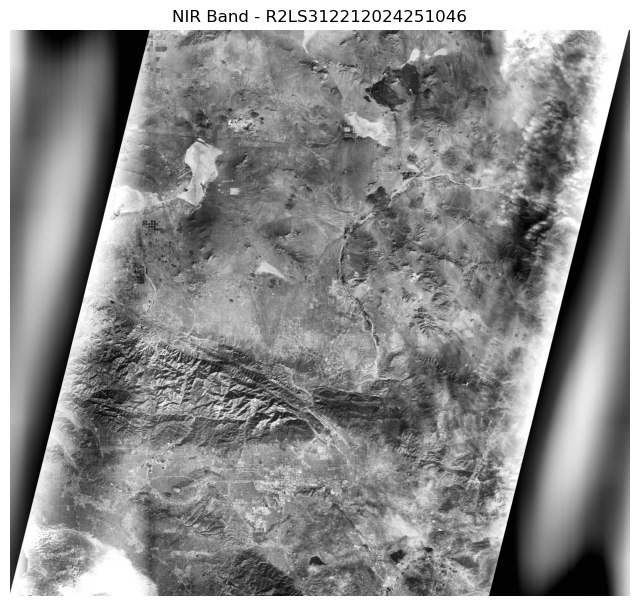


Processing complete! You can now proceed with classification once you've verified the data.


In [4]:
# Initialize processor with the LISS3 data directory
base_dir = "./LACAUS_LISS3_1slice"
processor = LISS3Processor(base_dir)

# Load TIF files from the base directory
print("Loading LISS3 images...")
processor.load_images()

# Process each loaded image
print("\nPreprocessing images...")
for img_name in processor.images.keys():
    print(f"Processing {img_name}")
    processor.preprocess_image(img_name)

# Initialize classifier
classifier = LISS3Classifier(processor)

# Create mask from provided shapefile
shapefile_path = "./LACAUS_LISS3_1slice/LACAUS_LISS3_202412_16_21_SHAPEFILE/irs_liss3_6784b6a8167f1a1f.shp"
print("\nCreating mask from shapefile...")
classifier.create_mask_from_shapefile(shapefile_path, "training_area")

# Optional: Create NDVI mask for vegetation
print("Creating NDVI mask...")
classifier.create_mask_from_indices("NDVI", threshold=0.3, mask_name="vegetation_mask")

# Assuming your shapefile has training polygons, let's print the classes
print("\nReading training data from shapefile...")
gdf = gpd.read_file(shapefile_path)
print("Available columns in shapefile:", gdf.columns.tolist())

# Print some sample rows to understand the structure
print("\nSample data from shapefile:")
print(gdf.head())

# At this point, you can examine the data and decide how to proceed with classification
# Let's just visualize one of the processed bands for now
print("\nPlotting processed bands for verification...")
for img_name in processor.processed_images.keys():
    plot_band(processor, img_name, band_idx=2, title=f"NIR Band - {img_name}")
    break  # Just plot the first image for now

print("\nProcessing complete! You can now proceed with classification once you've verified the data.")

Loading individual bands...

Processing scene: 2412121_251_46
Loading b2 from R2LS312212024251046_b2_l1t.tif
Loading b5 from R2LS312212024251046_b5_l1t.tif
3 from R2LS312212024251046_b3_l1t.tif

Loading b4 from R2LS312212024251046_b4_l1t.tif

Processing scene: 2412121_251_47
2 from R2LS312212024251047_b2_l1t.tif

Processing scene: 2412121_251_47

Loading b5 from R2LS312212024251047_b5_l1t.tif
Loading b4 from R2LS312212024251047_b4_l1t.tifing scene: 2412121_251_47

Loading b5 from R2LS312212024251047_b5_l1t.tif

Loading b3 from R2LS312212024251047_b3_l1t.tif

Processing scene: 241216_250_46
Loading b4 from R2LS312162024250046_b4_l1t.tif
Loading b2 from R2LS312162024250046_b2_l1t.tif
Loading b3 from R2LS312162024250046_b3_l1t.tifom R2LS312162024250046_b4_l1t.tif
Loading b2 from R2LS312162024250046_b2_l1t.tif

Loading b5 from R2LS312162024250046_b5_l1t.tif

Processing scene: 241216_250_47
Loading b5 from R2LS312162024250047_b5_l1t.tif
Loading b3 from R2LS312162024250047_b3_l1t.tif
Loading

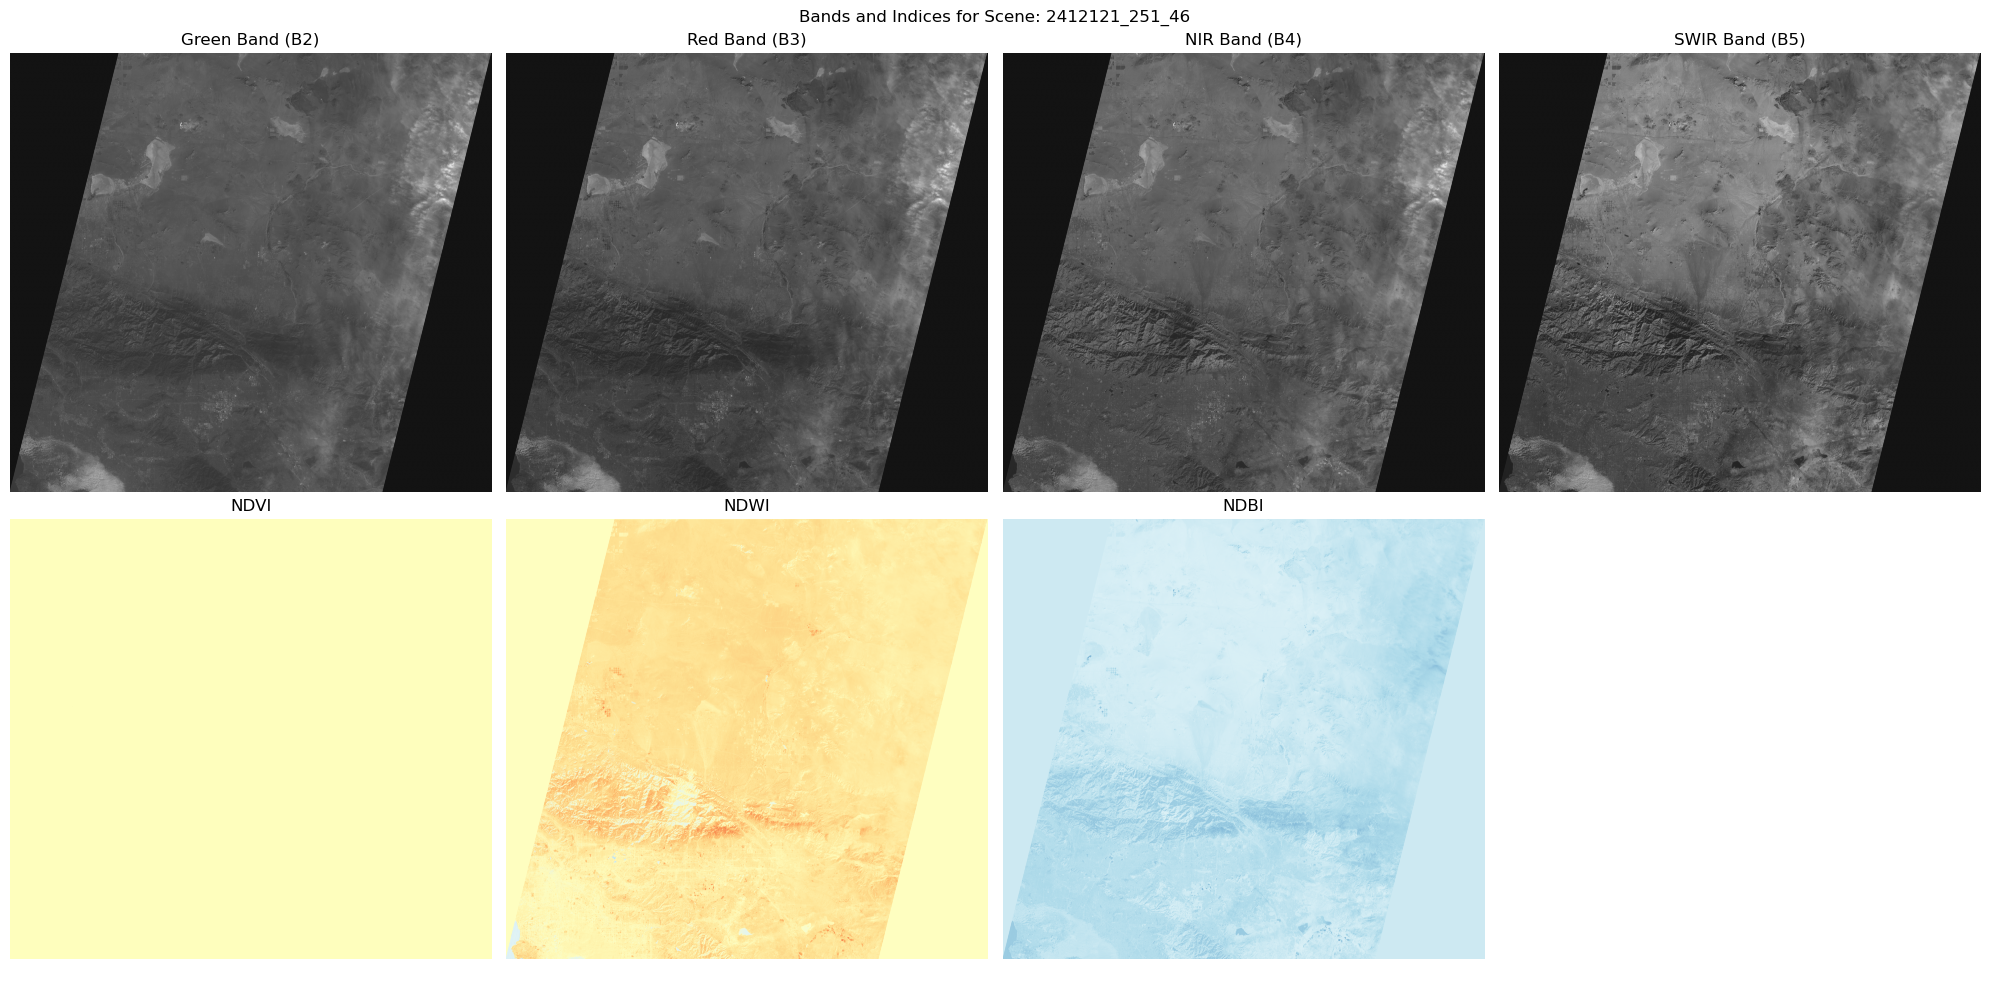


Processing complete!


In [5]:
# Define paths to the band directories
band_dirs = [
    "./LACAUS_LISS3_1slice/2412121_251_46",
    "./LACAUS_LISS3_1slice/2412121_251_47",
    "./LACAUS_LISS3_1slice/241216_250_46",
    "./LACAUS_LISS3_1slice/241216_250_47"
]

# Dictionary to store our band data
band_data = {}

# Load individual bands
print("Loading individual bands...")
for dir_path in band_dirs:
    scene_id = os.path.basename(dir_path)
    print(f"\nProcessing scene: {scene_id}")
    
    # Initialize lists for bands
    bands = {
        'b2': None,  # Green
        'b3': None,  # Red
        'b4': None,  # NIR
        'b5': None   # SWIR
    }
    
    # Load each band
    for band_file in os.listdir(dir_path):
        if band_file.endswith("_l1t.tif"):
            band_type = band_file.split("_")[-2]  # Extract b2, b3, b4, or b5
            print(f"Loading {band_type} from {band_file}")
            
            with rasterio.open(os.path.join(dir_path, band_file)) as src:
                # Store both data and metadata
                bands[band_type] = {
                    'data': src.read(1),
                    'profile': src.profile
                }
    
    band_data[scene_id] = bands

# Calculate indices for each scene
print("\nCalculating spectral indices...")
for scene_id, bands in band_data.items():
    print(f"\nProcessing indices for scene: {scene_id}")
    
    # Convert to float32 for calculations
    green = bands['b2']['data'].astype(np.float32)
    red = bands['b3']['data'].astype(np.float32)
    nir = bands['b4']['data'].astype(np.float32)
    swir = bands['b5']['data'].astype(np.float32)
    
    # Add small epsilon to prevent division by zero
    epsilon = 1e-10
    
    # Calculate NDVI
    ndvi = (nir - red) / (nir + red + epsilon)
    print(f"NDVI range: {ndvi.min():.3f} to {ndvi.max():.3f}")
    
    # Calculate NDWI
    ndwi = (green - nir) / (green + nir + epsilon)
    print(f"NDWI range: {ndwi.min():.3f} to {ndwi.max():.3f}")
    
    # Calculate NDBI
    ndbi = (swir - nir) / (swir + nir + epsilon)
    print(f"NDBI range: {ndbi.min():.3f} to {ndbi.max():.3f}")
    
    # Store the indices with the band data
    band_data[scene_id]['indices'] = {
        'ndvi': ndvi,
        'ndwi': ndwi,
        'ndbi': ndbi
    }

# Visualize the bands and indices for one scene
print("\nCreating visualizations...")
scene_id = list(band_data.keys())[0]  # Take first scene
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle(f'Bands and Indices for Scene: {scene_id}')

# Plot bands
axes[0,0].imshow(band_data[scene_id]['b2']['data'], cmap='gray')
axes[0,0].set_title('Green Band (B2)')
axes[0,1].imshow(band_data[scene_id]['b3']['data'], cmap='gray')
axes[0,1].set_title('Red Band (B3)')
axes[0,2].imshow(band_data[scene_id]['b4']['data'], cmap='gray')
axes[0,2].set_title('NIR Band (B4)')
axes[0,3].imshow(band_data[scene_id]['b5']['data'], cmap='gray')
axes[0,3].set_title('SWIR Band (B5)')

# Plot indices
axes[1,0].imshow(band_data[scene_id]['indices']['ndvi'], cmap='RdYlGn')
axes[1,0].set_title('NDVI')
axes[1,1].imshow(band_data[scene_id]['indices']['ndwi'], cmap='RdYlBu')
axes[1,1].set_title('NDWI')
axes[1,2].imshow(band_data[scene_id]['indices']['ndbi'], cmap='RdYlBu_r')
axes[1,2].set_title('NDBI')
axes[1,3].axis('off')  # Empty plot for symmetry

# Remove axes for better visualization
for ax in axes.flat:
    ax.set_axis_off()

plt.tight_layout()
plt.show()

print("\nProcessing complete!")

In [ ]:
import gc

def prepare_stack(scene_data):
    """Stack bands and indices for classification"""
    return np.stack([
        scene_data['b2']['data'],
        scene_data['b3']['data'],
        scene_data['b4']['data'],
        scene_data['b5']['data'],
        scene_data['indices']['ndvi'],
        scene_data['indices']['ndwi'],
        scene_data['indices']['ndbi'],
        scene_data['indices']['savi'],
        scene_data['indices']['ndmi']
    ])

# Function to process data in chunks
def process_chunk(chunk_data, epsilon=1e-10, L=0.5):
    """Process a chunk of data to calculate indices"""
    green, red, nir, swir = chunk_data
    
    # Calculate indices
    indices = {}
    
    # SAVI
    indices['savi'] = ((nir - red) / (nir + red + L + epsilon)) * (1 + L)
    
    # NDMI
    indices['ndmi'] = (nir - swir) / (nir + swir + epsilon)
    
    return indices

# Function to chunk the data
def create_chunks(data, chunk_size=1000):
    """Split data into chunks"""
    total_pixels = data.shape[1] * data.shape[2]
    for i in range(0, total_pixels, chunk_size):
        yield data.reshape(data.shape[0], -1)[:, i:i+chunk_size]

# Process indices in chunks
print("\nCalculating additional spectral indices...")
chunk_size = 256  # Adjust based on your RAM

for scene_id, bands in band_data.items():
    print(f"\nProcessing advanced indices for scene: {scene_id}")
    
    # Initialize arrays for indices
    shape = bands['b2']['data'].shape
    total_pixels = shape[0] * shape[1]
    
    savi_data = np.zeros(total_pixels)
    ndmi_data = np.zeros(total_pixels)
    
    # Process in chunks
    chunk_data = np.stack([
        bands['b2']['data'].astype(np.float32),
        bands['b3']['data'].astype(np.float32),
        bands['b4']['data'].astype(np.float32),
        bands['b5']['data'].astype(np.float32)
    ])
    
    current_pos = 0
    for chunk in create_chunks(chunk_data, chunk_size):
        # Process chunk
        indices = process_chunk(chunk)
        
        # Store results
        chunk_len = chunk.shape[1]
        savi_data[current_pos:current_pos+chunk_len] = indices['savi']
        ndmi_data[current_pos:current_pos+chunk_len] = indices['ndmi']
        
        current_pos += chunk_len
        
        # Force garbage collection
        gc.collect()
    
    # Reshape back to original dimensions
    bands['indices'].update({
        'savi': savi_data.reshape(shape),
        'ndmi': ndmi_data.reshape(shape)
    })
    
    # Print ranges
    print(f"SAVI range: {bands['indices']['savi'].min():.3f} to {bands['indices']['savi'].max():.3f}")
    print(f"NDMI range: {bands['indices']['ndmi'].min():.3f} to {bands['indices']['ndmi'].max():.3f}")

# Prepare data for classification in chunks
print("\nPreparing data for classification...")

def process_classification_chunk(chunk_data, n_clusters=5):
    """Process a chunk for classification"""
    # Standardize the chunk
    scaler = StandardScaler()
    chunk_scaled = scaler.fit_transform(chunk_data)
    
    # Perform clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    return kmeans.fit_predict(chunk_scaled)

# Process each scene
for scene_id, data in band_data.items():
    print(f"\nProcessing scene: {scene_id}")
    
    # Stack data
    stack = prepare_stack(data)
    rows, cols = stack.shape[1], stack.shape[2]
    
    # Initialize output array
    classified_data = np.zeros(rows * cols, dtype=np.int32)
    
    # Process in chunks
    current_pos = 0
    for chunk in create_chunks(stack, chunk_size):
        # Transpose chunk for classification
        chunk_t = chunk.T
        
        # Classify chunk
        labels = process_classification_chunk(chunk_t, n_clusters=5)
        
        # Store results
        chunk_len = len(labels)
        classified_data[current_pos:current_pos+chunk_len] = labels
        
        current_pos += chunk_len
        
        # Clean up
        gc.collect()
    
    # Reshape result
    classified_image = classified_data.reshape(rows, cols)
    
    # Visualize results
    plt.figure(figsize=(15, 5))
    
    plt.subplot(131)
    plt.imshow(data['b4']['data'], cmap='gray')
    plt.title('NIR Band')
    plt.axis('off')
    
    plt.subplot(132)
    plt.imshow(data['indices']['ndvi'], cmap='RdYlGn')
    plt.title('NDVI')
    plt.axis('off')
    
    plt.subplot(133)
    plt.imshow(classified_image, cmap='tab10')
    plt.title('Unsupervised Classification\n(5 classes)')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Clean up after visualization
    plt.close()
    gc.collect()

print("\nClassification complete!")


Calculating additional spectral indices...

Processing advanced indices for scene: 2412121_251_46


In [8]:
gc.collect()

110239

In [7]:
def normalize_array(arr):
    """Efficiently normalize array to 0-1 range"""
    arr_min = arr.min()
    return (arr - arr_min) / (arr.max() - arr_min)

def process_scene_data(scene_id, data, output_dir, chunk_size=1024):
    """Process single scene with memory efficiency"""
    print(f"\nProcessing scene: {scene_id}")
    
    # Get image dimensions once
    shape = data['b2']['data'].shape
    rows, cols = shape
    
    # Create smaller figure for key visualizations
    fig = plt.figure(figsize=(16, 10))
    
    # 1. Process and display RGB (top-left)
    print("Creating RGB composite...")
    ax1 = plt.subplot(231)
    rgb = np.dstack([
        normalize_array(data['b3']['data']),  # R
        normalize_array(data['b2']['data']),  # G
        normalize_array(data['b2']['data'])   # G for B
    ])
    ax1.imshow(rgb)
    ax1.set_title('RGB')
    ax1.axis('off')
    
    # 2. NIR Composite (top-middle)
    print("Creating NIR composite...")
    ax2 = plt.subplot(232)
    nir_rgb = np.dstack([
        normalize_array(data['b4']['data']),  # NIR
        normalize_array(data['b3']['data']),  # R
        normalize_array(data['b2']['data'])   # G
    ])
    ax2.imshow(nir_rgb)
    ax2.set_title('NIR False Color')
    ax2.axis('off')
    
    # 3. Process indices in chunks to save memory
    print("Processing indices...")
    indices = {}
    epsilon = 1e-10
    
    # Prepare memory-efficient arrays
    for idx in ['ndvi', 'ndwi', 'ndbi', 'savi']:
        indices[idx] = np.zeros(shape)
    
    # Process in chunks
    for i in range(0, rows, chunk_size):
        chunk_end = min(i + chunk_size, rows)
        
        # Get chunk data
        red = data['b3']['data'][i:chunk_end]
        nir = data['b4']['data'][i:chunk_end]
        green = data['b2']['data'][i:chunk_end]
        swir = data['b5']['data'][i:chunk_end]
        
        # Calculate indices for chunk
        indices['ndvi'][i:chunk_end] = (nir - red) / (nir + red + epsilon)
        indices['ndwi'][i:chunk_end] = (green - nir) / (green + nir + epsilon)
        indices['ndbi'][i:chunk_end] = (swir - nir) / (swir + nir + epsilon)
        
        L = 0.5
        indices['savi'][i:chunk_end] = ((nir - red) / (nir + red + L + epsilon)) * (1 + L)
    
    # 4. Display key indices
    print("Plotting indices...")
    index_plots = {
        'ndvi': ('NDVI', 'RdYlGn', 233),
        'ndwi': ('NDWI', 'RdYlBu', 234),
        'ndbi': ('NDBI', 'RdYlBu_r', 235)
    }
    
    for idx, (title, cmap, pos) in index_plots.items():
        ax = plt.subplot(pos)
        im = ax.imshow(indices[idx], cmap=cmap)
        plt.colorbar(im, ax=ax)
        ax.set_title(title)
        ax.axis('off')
    
    # 5. Classification
    print("Performing classification...")
    # Stack selected bands and indices for classification
    stack = np.stack([
        normalize_array(data['b4']['data']),  # NIR
        normalize_array(data['b3']['data']),  # R
        indices['ndvi'],
        indices['ndwi']
    ])
    
    # Reshape for classification
    X = stack.reshape(stack.shape[0], -1).T
    
    # Memory efficient clustering
    n_clusters = 5
    kmeans = MiniBatchKMeans(n_clusters=n_clusters, 
                            batch_size=1024,
                            random_state=42)
    labels = kmeans.fit_predict(X)
    classified = labels.reshape(rows, cols)
    
    # Plot classification
    ax6 = plt.subplot(236)
    im = ax6.imshow(classified, cmap='tab10')
    plt.colorbar(im, ax=ax6)
    ax6.set_title('Classification')
    ax6.axis('off')
    
    # Save plot
    plt.suptitle(f'Scene Analysis - {scene_id}')
    plt.tight_layout()
    
    # Save results
    print("Saving results...")
    os.makedirs(output_dir, exist_ok=True)
    plt.savefig(f"{output_dir}/analysis_{scene_id}.png", 
                dpi=300, bbox_inches='tight')
    plt.close()
    
    # Save classification for further analysis
    np.save(f"{output_dir}/classification_{scene_id}.npy", classified)
    
    # Clean up
    del indices, stack, X, labels
    gc.collect()
    
    return classified

# Main processing loop
from sklearn.cluster import MiniBatchKMeans

results_dir = "./results"
os.makedirs(results_dir, exist_ok=True)

# Process each scene
all_classifications = {}
for scene_id, data in band_data.items():
    print(f"\nProcessing scene {scene_id}...")
    
    scene_dir = f"{results_dir}/{scene_id}"
    classified = process_scene_data(scene_id, data, scene_dir)
    all_classifications[scene_id] = classified
    
    # Force cleanup
    gc.collect()
    print(f"Completed scene {scene_id}")

print("\nProcessing complete!")


Processing scene 2412121_251_46...

Processing scene: 2412121_251_46
Creating RGB composite...
Creating NIR composite...
Processing indices...e...

lotting indices.....e...


Performing classification...
Saving results...fication...

Completed scene 2412121_251_46

Processing scene 2412121_251_47...

Processing scene: 2412121_251_47
Creating RGB composite...
reating NIR composite...51_46

Processing scene 2412121_251_47...

Processing scene: 2412121_251_47
Creating RGB composite...

Processing indices......51_46

Processing scene 2412121_251_47...

Processing scene: 2412121_251_47
Creating RGB composite...


lotting indices........51_46

Processing scene 2412121_251_47...

Processing scene: 2412121_251_47
Creating RGB composite...



Performing classification...

Processing scene 2412121_251_47...

Processing scene: 2412121_251_47
Creating RGB composite...




Saving results...fication...

Processing scene 2412121_251_47...

Processing scene: 2412121_251_47
Creating RGB composite...



In [ ]:
# --- Deffered
def create_comprehensive_visualization(scene_id, data, classified_image, output_dir=None):
    """Create a comprehensive visualization of all bands, indices, and classification"""
    plt.style.use('seaborn')
    
    # Create a large figure for all visualizations
    fig = plt.figure(figsize=(20, 15))
    gs = fig.add_gridspec(3, 4)
    
    # 1. RGB Composite (Top Left)
    ax_rgb = fig.add_subplot(gs[0, 0])
    # Create RGB composite using Red, Green, Blue bands
    rgb = np.dstack([
        data['b3']['data'],  # Red
        data['b2']['data'],  # Green
        data['b2']['data']   # Use Green for Blue since we don't have blue band
    ])
    # Normalize for visualization
    rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min())
    ax_rgb.imshow(rgb)
    ax_rgb.set_title('RGB Composite')
    ax_rgb.axis('off')
    
    # 2. NIR False Color (Top Second)
    ax_nir = fig.add_subplot(gs[0, 1])
    nir_rgb = np.dstack([
        data['b4']['data'],  # NIR as Red
        data['b3']['data'],  # Red as Green
        data['b2']['data']   # Green as Blue
    ])
    nir_rgb = (nir_rgb - nir_rgb.min()) / (nir_rgb.max() - nir_rgb.min())
    ax_nir.imshow(nir_rgb)
    ax_nir.set_title('NIR False Color')
    ax_nir.axis('off')
    
    # 3. Classification Result (Top Right Two Panels)
    ax_class = fig.add_subplot(gs[0, 2:])
    class_plot = ax_class.imshow(classified_image, cmap='tab20')
    ax_class.set_title('Classification Result')
    ax_class.axis('off')
    plt.colorbar(class_plot, ax=ax_class, label='Class')
    
    # 4. Spectral Indices (Middle Row)
    indices = ['ndvi', 'ndwi', 'ndbi', 'savi']
    cmaps = ['RdYlGn', 'RdYlBu', 'RdYlBu_r', 'YlGn']
    
    for i, (idx, cmap) in enumerate(zip(indices, cmaps)):
        ax = fig.add_subplot(gs[1, i])
        im = ax.imshow(data['indices'][idx], cmap=cmap)
        ax.set_title(f'{idx.upper()}')
        ax.axis('off')
        plt.colorbar(im, ax=ax)
    
    # 5. Individual Bands (Bottom Row)
    bands = ['b2', 'b3', 'b4', 'b5']
    band_names = ['Green', 'Red', 'NIR', 'SWIR']
    
    for i, (band, name) in enumerate(zip(bands, band_names)):
        ax = fig.add_subplot(gs[2, i])
        im = ax.imshow(data[band]['data'], cmap='gray')
        ax.set_title(f'{name} Band')
        ax.axis('off')
        plt.colorbar(im, ax=ax)
    
    # Add super title
    plt.suptitle(f'Comprehensive Analysis - Scene {scene_id}', fontsize=16, y=0.95)
    plt.tight_layout()
    
    # Save if output directory is provided
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
        plt.savefig(os.path.join(output_dir, f'comprehensive_analysis_{scene_id}.png'), 
                   dpi=300, bbox_inches='tight')
        plt.close()
    else:
        plt.show()

def create_classification_analysis(scene_id, data, classified_image, output_dir=None):
    """Create detailed analysis of the classification results"""
    plt.style.use('seaborn')
    fig = plt.figure(figsize=(20, 10))
    
    # 1. Original vs Classification
    ax1 = plt.subplot(231)
    rgb = np.dstack([
        data['b3']['data'],
        data['b2']['data'],
        data['b2']['data']
    ])
    rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min())
    ax1.imshow(rgb)
    ax1.set_title('RGB Composite')
    ax1.axis('off')
    
    ax2 = plt.subplot(232)
    class_plot = ax2.imshow(classified_image, cmap='tab20')
    ax2.set_title('Classification')
    ax2.axis('off')
    plt.colorbar(class_plot, ax=ax2)
    
    # 2. Classification overlaid on RGB
    ax3 = plt.subplot(233)
    overlay = ax3.imshow(rgb)
    overlay2 = ax3.imshow(classified_image, cmap='tab20', alpha=0.5)
    ax3.set_title('Classification Overlay')
    ax3.axis('off')
    
    # 3. Class Distribution
    ax4 = plt.subplot(234)
    unique, counts = np.unique(classified_image, return_counts=True)
    ax4.bar(unique, counts)
    ax4.set_title('Class Distribution')
    ax4.set_xlabel('Class')
    ax4.set_ylabel('Pixel Count')
    
    # 4. NDVI Distribution per Class
    ax5 = plt.subplot(235)
    ndvi = data['indices']['ndvi']
    for class_id in unique:
        mask = classified_image == class_id
        ndvi_class = ndvi[mask]
        ax5.hist(ndvi_class, bins=50, alpha=0.3, label=f'Class {class_id}')
    ax5.set_title('NDVI Distribution by Class')
    ax5.set_xlabel('NDVI Value')
    ax5.legend()
    
    # 5. Classification Boundaries
    ax6 = plt.subplot(236)
    boundaries = np.zeros_like(classified_image)
    boundaries[1:] += (classified_image[1:] != classified_image[:-1])
    boundaries[:, 1:] += (classified_image[:, 1:] != classified_image[:, :-1])
    ax6.imshow(rgb)
    ax6.imshow(boundaries > 0, cmap='hot', alpha=0.5)
    ax6.set_title('Classification Boundaries')
    ax6.axis('off')
    
    plt.suptitle(f'Classification Analysis - Scene {scene_id}', fontsize=16)
    plt.tight_layout()
    
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
        plt.savefig(os.path.join(output_dir, f'classification_analysis_{scene_id}.png'), 
                   dpi=300, bbox_inches='tight')
        plt.close()
    else:
        plt.show()

# Use these functions after classification
for scene_id, data in band_data.items():
    # Create output directory
    output_dir = f"./results/{scene_id}"
    os.makedirs(output_dir, exist_ok=True)
    
    # Create visualizations
    create_comprehensive_visualization(scene_id, data, classified_image, output_dir)
    create_classification_analysis(scene_id, data, classified_image, output_dir)
    
    # Clear memory
    gc.collect()

In [ ]:
import numpy as np
from sklearn.cluster import KMeans, DBSCAN
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy.ndimage import gaussian_filter
from typing import Dict, List, Tuple, Optional
import numpy.typing as npt

class ISODATAClustering:
    """Implementation of ISODATA clustering algorithm"""
    def __init__(self, n_clusters_min: int = 5, n_clusters_max: int = 10,
                 min_samples: int = 7, max_iterations: int = 100):
        self.n_clusters_min = n_clusters_min
        self.n_clusters_max = n_clusters_max
        self.min_samples = min_samples
        self.max_iterations = max_iterations
        
    def fit_predict(self, X: npt.NDArray) -> npt.NDArray:
        # Initialize with K-means using maximum clusters
        kmeans = KMeans(n_clusters=self.n_clusters_max, random_state=42)
        labels = kmeans.fit_predict(X)
        centers = kmeans.cluster_centers_
        
        for _ in range(self.max_iterations):
            # Calculate cluster statistics
            unique_labels = np.unique(labels)
            n_clusters = len(unique_labels)
            
            # Check each cluster
            new_centers = []
            new_labels = labels.copy()
            
            for label in unique_labels:
                cluster_points = X[labels == label]
                
                # Skip if too few samples
                if len(cluster_points) < self.min_samples:
                    continue
                
                # Calculate standard deviation
                std_dev = np.std(cluster_points, axis=0)
                
                # Split cluster if variance is high and we're below max clusters
                if np.max(std_dev) > np.mean(std_dev) * 2 and n_clusters < self.n_clusters_max:
                    # Split into two subclusters
                    sub_kmeans = KMeans(n_clusters=2, random_state=42)
                    sub_labels = sub_kmeans.fit_predict(cluster_points)
                    
                    # Update centers and labels
                    new_centers.extend(sub_kmeans.cluster_centers_)
                    new_labels[labels == label] = n_clusters + sub_labels
                    n_clusters += 2
                else:
                    new_centers.append(np.mean(cluster_points, axis=0))
            
            # Update centers and check convergence
            if np.array_equal(labels, new_labels):
                break
                
            labels = new_labels
            centers = np.array(new_centers)
            
        return labels

class SpatialContinuityLoss(nn.Module):
    """Loss function to enforce spatial continuity in segmentation"""
    def __init__(self, weight: float = 1.0):
        super().__init__()
        self.weight = weight
        
    def forward(self, pred: torch.Tensor) -> torch.Tensor:
        # Calculate gradients in both directions
        dx = torch.abs(pred[:, :, 1:, :] - pred[:, :, :-1, :])
        dy = torch.abs(pred[:, :, :, 1:] - pred[:, :, :, :-1])
        
        # Total variation loss
        loss = torch.mean(dx) + torch.mean(dy)
        return self.weight * loss

class SoftPatchPlusClassifier:
    """Implementation of SoftPatch+ algorithm with spatial constraints"""
    def __init__(self, patch_size: int = 7, n_clusters: int = 5):
        self.patch_size = patch_size
        self.n_clusters = n_clusters
        
    def extract_patches(self, X: npt.NDArray) -> npt.NDArray:
        """Extract overlapping patches from the image"""
        patches = []
        pad = self.patch_size // 2
        X_padded = np.pad(X, ((0, 0), (pad, pad), (pad, pad)), mode='reflect')
        
        for i in range(pad, X_padded.shape[1] - pad):
            for j in range(pad, X_padded.shape[2] - pad):
                patch = X_padded[:, 
                               i-pad:i+pad+1,
                               j-pad:j+pad+1]
                patches.append(patch.reshape(-1))
                
        return np.array(patches)
    
    def fit_predict(self, X: npt.NDArray) -> npt.NDArray:
        # Extract patches
        patches = self.extract_patches(X)
        
        # Cluster patches
        kmeans = KMeans(n_clusters=self.n_clusters, random_state=42)
        labels = kmeans.fit_predict(patches)
        
        # Reshape back to image dimensions
        return labels.reshape(X.shape[1]-self.patch_size+1,
                            X.shape[2]-self.patch_size+1)

class EnsembleUnsupervisedClassifier:
    """Ensemble of multiple unsupervised classifiers with spatial refinement"""
    def __init__(self, 
                 n_clusters: int = 5,
                 spatial_weight: float = 1.0,
                 refinement_iterations: int = 3):
        self.n_clusters = n_clusters
        self.spatial_weight = spatial_weight
        self.refinement_iterations = refinement_iterations
        
        # Initialize classifiers
        self.classifiers = {
            'isodata': ISODATAClustering(n_clusters_min=n_clusters-2, 
                                       n_clusters_max=n_clusters+2),
            'dbscan': DBSCAN(eps=0.3, min_samples=10),
            'kmeans': KMeans(n_clusters=n_clusters),
            'softpatch': SoftPatchPlusClassifier(n_clusters=n_clusters)
        }
        
        self.spatial_loss = SpatialContinuityLoss(weight=spatial_weight)
        
    def preprocess_data(self, X: npt.NDArray) -> npt.NDArray:
        """Standardize and reshape data"""
        scaler = StandardScaler()
        shape = X.shape
        X_flat = X.reshape(shape[0], -1).T
        X_scaled = scaler.fit_transform(X_flat)
        return X_scaled, shape
    
    def apply_spatial_smoothing(self, labels: npt.NDArray) -> npt.NDArray:
        """Apply spatial smoothing to labels"""
        # Convert to one-hot encoding
        unique_labels = np.unique(labels)
        one_hot = np.zeros((len(unique_labels), *labels.shape))
        
        for i, label in enumerate(unique_labels):
            one_hot[i] = (labels == label)
        
        # Apply Gaussian smoothing
        smoothed = gaussian_filter(one_hot, sigma=1.0)
        
        # Convert back to labels
        return unique_labels[np.argmax(smoothed, axis=0)]
    
    def get_ensemble_prediction(self, X: npt.NDArray) -> npt.NDArray:
        """Combine predictions from all classifiers"""
        predictions = {}
        X_scaled, original_shape = self.preprocess_data(X)
        
        # Get predictions from each classifier
        for name, clf in self.classifiers.items():
            try:
                pred = clf.fit_predict(X_scaled)
                pred = pred.reshape(original_shape[1:])
                predictions[name] = pred
            except Exception as e:
                print(f"Warning: {name} classifier failed with error: {str(e)}")
        
        # Stack predictions
        pred_stack = np.stack(list(predictions.values()))
        
        # Convert to torch tensor for spatial loss calculation
        pred_tensor = torch.FloatTensor(pred_stack).unsqueeze(0)
        
        # Initialize final prediction
        final_pred = np.zeros(original_shape[1:])
        
        # Iterative refinement with spatial constraints
        for _ in range(self.refinement_iterations):
            # Calculate spatial loss
            spatial_loss = self.spatial_loss(pred_tensor)
            
            # Update predictions based on majority voting and spatial loss
            for i in range(original_shape[1]):
                for j in range(original_shape[2]):
                    votes = pred_stack[:, i, j]
                    unique, counts = np.unique(votes, return_counts=True)
                    
                    # Weight votes by spatial continuity
                    if i > 0:
                        counts[unique == final_pred[i-1, j]] += self.spatial_weight
                    if j > 0:
                        counts[unique == final_pred[i, j-1]] += self.spatial_weight
                    
                    final_pred[i, j] = unique[np.argmax(counts)]
            
            # Apply spatial smoothing
            final_pred = self.apply_spatial_smoothing(final_pred)
            
        return final_pred

def create_segmentation_map(classification: npt.NDArray,
                          indices: Dict[str, npt.NDArray]) -> Tuple[npt.NDArray, Dict]:
    """Create a detailed segmentation map with class interpretations"""
    # Initialize class mapping
    class_map = {}
    
    # Analyze each class using indices
    for class_label in np.unique(classification):
        mask = (classification == class_label)
        
        # Calculate mean index values for this class
        class_properties = {
            'ndvi_mean': np.mean(indices['ndvi'][mask]),
            'ndwi_mean': np.mean(indices['ndwi'][mask]),
            'savi_mean': np.mean(indices['savi'][mask]),
            'ndmi_mean': np.mean(indices['ndmi'][mask])
        }
        
        # Interpret class based on index values
        if class_properties['ndvi_mean'] > 0.5:
            class_map[class_label] = 'Dense Vegetation'
        elif class_properties['ndwi_mean'] > 0.3:
            class_map[class_label] = 'Water Body'
        elif class_properties['ndvi_mean'] > 0.2:
            class_map[class_label] = 'Sparse Vegetation'
        elif class_properties['savi_mean'] > 0.2:
            class_map[class_label] = 'Soil/Urban'
        else:
            class_map[class_label] = 'Barren/Built-up'
            
    return classification, class_map

def plot_segmentation_results(original_image: npt.NDArray,
                            segmentation: npt.NDArray,
                            class_map: Dict,
                            indices: Dict[str, npt.NDArray]) -> None:
    """Plot comprehensive segmentation results"""
    plt.figure(figsize=(20, 10))
    
    # Original image (NIR composite)
    plt.subplot(231)
    plt.imshow(original_image, cmap='gray')
    plt.title('Original Image (NIR)')
    plt.axis('off')
    
    # Segmentation map
    plt.subplot(232)
    seg_plot = plt.imshow(segmentation, cmap='tab20')
    plt.title('Segmentation Map')
    plt.colorbar(seg_plot)
    plt.axis('off')
    
    # NDVI
    plt.subplot(233)
    plt.imshow(indices['ndvi'], cmap='RdYlGn')
    plt.title('NDVI')
    plt.colorbar()
    plt.axis('off')
    
    # Class distribution
    plt.subplot(234)
    unique, counts = np.unique(segmentation, return_counts=True)
    plt.bar([class_map[u] for u in unique], counts)
    plt.xticks(rotation=45, ha='right')
    plt.title('Class Distribution')
    
    # Boundary overlay
    plt.subplot(235)
    boundaries = np.zeros_like(segmentation)
    boundaries[1:] += (segmentation[1:] != segmentation[:-1])
    boundaries[:, 1:] += (segmentation[:, 1:] != segmentation[:, :-1])
    plt.imshow(original_image, cmap='gray')
    plt.imshow(boundaries > 0, cmap='hot', alpha=0.3)
    plt.title('Boundary Overlay')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

In [ ]:
import os
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple, Optional
from tqdm import tqdm  # For progress bars
import gc  # For garbage collection

# Function to chunk the image into smaller patches
def create_patches(image, patch_size=256, overlap=32):
    """Create overlapping patches from the image."""
    rows, cols = image.shape[-2:]
    patches = []
    coords = []
    
    r_idx = list(range(0, rows-patch_size, patch_size-overlap)) + [rows-patch_size]
    c_idx = list(range(0, cols-patch_size, patch_size-overlap)) + [cols-patch_size]
    
    for r in r_idx:
        for c in c_idx:
            patch = image[..., r:r+patch_size, c:c+patch_size]
            patches.append(patch)
            coords.append((r, c))
            
    return patches, coords

# Function to stitch patches back together
def stitch_patches(patches, coords, original_shape, patch_size=256):
    """Stitch patches back into full image."""
    result = np.zeros(original_shape, dtype=patches[0].dtype)
    count = np.zeros(original_shape, dtype=np.int32)
    
    for patch, (r, c) in zip(patches, coords):
        result[..., r:r+patch_size, c:c+patch_size] += patch
        count[..., r:r+patch_size, c:c+patch_size] += 1
    
    # Average overlapping regions
    count = np.maximum(count, 1)
    result = result / count
    
    return result

# Modified band loading function with memory optimization
def load_and_process_bands(dir_path, patch_size=256):
    """Load and process bands with memory optimization."""
    scene_id = os.path.basename(dir_path)
    print(f"\nProcessing scene: {scene_id}")
    
    bands = {}
    
    # First, just get the metadata
    for band_file in os.listdir(dir_path):
        if band_file.endswith("_l1t.tif"):
            band_type = band_file.split("_")[-2]
            with rasterio.open(os.path.join(dir_path, band_file)) as src:
                bands[band_type] = {
                    'profile': src.profile,
                    'path': os.path.join(dir_path, band_file)
                }
    
    return scene_id, bands

# Process data in chunks
print("Loading and processing scenes...")
band_data = {}
patch_size = 256  # Adjust based on your available memory

# First, load metadata for all scenes
for dir_path in band_dirs:
    scene_id, bands = load_and_process_bands(dir_path)
    band_data[scene_id] = bands

# Process each scene
for scene_id, bands in band_data.items():
    print(f"\nProcessing scene: {scene_id}")
    
    # Initialize arrays for indices
    with rasterio.open(bands['b4']['path']) as src:
        shape = src.shape
        bands['indices'] = {}
    
    # Process in patches
    patches_dict = {}
    coords_dict = {}
    
    # Load and create patches for each band
    for band_type in ['b2', 'b3', 'b4', 'b5']:
        with rasterio.open(bands[band_type]['path']) as src:
            data = src.read(1).astype(np.float32)
            patches, coords = create_patches(data)
            patches_dict[band_type] = patches
            coords_dict[band_type] = coords
    
    # Calculate indices for each patch
    ndvi_patches = []
    ndwi_patches = []
    ndbi_patches = []
    savi_patches = []
    ndmi_patches = []
    
    for i in tqdm(range(len(patches_dict['b2'])), desc="Processing patches"):
        # Get band patches
        green = patches_dict['b2'][i]
        red = patches_dict['b3'][i]
        nir = patches_dict['b4'][i]
        swir = patches_dict['b5'][i]
        epsilon = 1e-10
        
        # Calculate indices
        ndvi = (nir - red) / (nir + red + epsilon)
        ndwi = (green - nir) / (green + nir + epsilon)
        ndbi = (swir - nir) / (swir + nir + epsilon)
        
        L = 0.5
        savi = ((nir - red) / (nir + red + L + epsilon)) * (1 + L)
        ndmi = (nir - swir) / (nir + swir + epsilon)
        
        # Store patches
        ndvi_patches.append(ndvi)
        ndwi_patches.append(ndwi)
        ndbi_patches.append(ndbi)
        savi_patches.append(savi)
        ndmi_patches.append(ndmi)
    
    # Stitch patches back together
    bands['indices']['ndvi'] = stitch_patches(ndvi_patches, coords_dict['b2'], shape)
    bands['indices']['ndwi'] = stitch_patches(ndwi_patches, coords_dict['b2'], shape)
    bands['indices']['ndbi'] = stitch_patches(ndbi_patches, coords_dict['b2'], shape)
    bands['indices']['savi'] = stitch_patches(savi_patches, coords_dict['b2'], shape)
    bands['indices']['ndmi'] = stitch_patches(ndmi_patches, coords_dict['b2'], shape)
    
    # Clear memory
    del patches_dict, coords_dict, ndvi_patches, ndwi_patches, ndbi_patches, savi_patches, ndmi_patches
    gc.collect()
    
    # Process classification in patches
    ensemble_clf = EnsembleUnsupervisedClassifier(
        n_clusters=7,
        spatial_weight=1.5,
        refinement_iterations=5
    )
    
    segmentation_patches = []
    
    # Prepare patches for classification
    for i in tqdm(range(len(coords_dict['b2'])), desc="Classifying patches"):
        patch_stack = np.stack([
            patches_dict['b2'][i],
            patches_dict['b3'][i],
            patches_dict['b4'][i],
            patches_dict['b5'][i],
            ndvi_patches[i],
            ndwi_patches[i],
            ndbi_patches[i],
            savi_patches[i],
            ndmi_patches[i]
        ])
        
        # Classify patch
        seg_patch = ensemble_clf.get_ensemble_prediction(patch_stack)
        segmentation_patches.append(seg_patch)
    
    # Stitch segmentation patches
    segmentation = stitch_patches(segmentation_patches, coords_dict['b2'], shape)
    
    # Create and save results
    output_dir = f"./results/{scene_id}"
    os.makedirs(output_dir, exist_ok=True)
    
    # Save intermediate results
    np.save(f"{output_dir}/segmentation.npy", segmentation)
    
    # Clear memory again
    gc.collect()

print("\nProcessing complete!")

# Now load and visualize results
for scene_id in band_data.keys():
    print(f"\nVisualizing results for scene: {scene_id}")
    
    # Load segmentation
    segmentation = np.load(f"./results/{scene_id}/segmentation.npy")
    
    # Create detailed segmentation map
    segmentation_map, class_map = create_segmentation_map(
        segmentation,
        band_data[scene_id]['indices']
    )
    
    # Plot results
    plot_segmentation_results(
        original_image=band_data[scene_id]['b4']['data'],
        segmentation=segmentation_map,
        class_map=class_map,
        indices=band_data[scene_id]['indices']
    )

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from typing import Optional, Tuple, List

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)  # Should print 'cuda' if a GPU is available, otherwise 'cpu'


In [ ]:
class SineActivation(nn.Module):
    """SIREN-style sinusoidal activation"""
    def __init__(self, w0: float = 1.0):
        super().__init__()
        self.w0 = w0
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return torch.sin(self.w0 * x)

class SpatialEmbedding(nn.Module):
    """Positional encoding for spatial coordinates"""
    def __init__(self, num_freqs: int = 6, include_identity: bool = True):
        super().__init__()
        self.num_freqs = num_freqs
        self.include_identity = include_identity
        
    def forward(self, coords: torch.Tensor) -> torch.Tensor:
        """
        Args:
            coords: [B, 2, H, W] tensor of normalized coordinates
        Returns:
            embedded: [B, C, H, W] where C = 2 + 4*num_freqs if include_identity
        """
        # Calculate frequencies
        freqs = 2.0 ** torch.arange(self.num_freqs, device=coords.device)
        
        # Scale coords: [B, 2, H, W] -> [B, 2, 1, H, W]
        scaled_coords = coords.unsqueeze(2)  # Add frequency dimension
        
        # Scale with frequencies: [1, 1, F, 1, 1]
        freqs = freqs.view(1, 1, -1, 1, 1)
        
        # Multiply: [B, 2, F, H, W]
        scaled_coords = scaled_coords * freqs
        
        # Calculate sine and cosine: [B, 2, F, H, W]
        sines = torch.sin(2 * math.pi * scaled_coords)
        cosines = torch.cos(2 * math.pi * scaled_coords)
        
        # Combine and reshape: [B, 4*F, H, W]
        B, _, H, W = coords.shape
        embedded = torch.cat([
            sines.reshape(B, -1, H, W),
            cosines.reshape(B, -1, H, W)
        ], dim=1)
        
        if self.include_identity:
            embedded = torch.cat([coords, embedded], dim=1)
            
        return embedded

class TransformerBlock(nn.Module):
    """Self-attention transformer block with MLP"""
    def __init__(self, dim: int, num_heads: int = 8, mlp_ratio: float = 4.0, dropout: float = 0.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(dim, num_heads, dropout=dropout, batch_first=True)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, int(dim * mlp_ratio)),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(int(dim * mlp_ratio), dim),
            nn.Dropout(dropout)
        )
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: [B, N, D]
        h = self.norm1(x)
        h, _ = self.attn(h, h, h)
        x = x + h
        
        h = self.norm2(x)
        h = self.mlp(h)
        x = x + h
        return x

class ConvBlock(nn.Module):
    """Convolutional block with SIREN activation"""
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int = 3, 
                 stride: int = 1, padding: int = 1, w0: float = 1.0):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.activation = SineActivation(w0)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.activation(self.conv(x))

class DiffusionUNet(nn.Module):
    """SIREN U-Net with transformer blocks for diffusion model"""
    def __init__(self, in_channels: int, out_channels: int = 2, base_channels: int = 64,
                 time_embed_dim: int = 256, num_heads: int = 8, transformer_layers: int = 2,
                 w0: float = 1.0):
        super().__init__()
        
        # Time embedding
        self.time_embed = nn.Sequential(
            nn.Linear(time_embed_dim, 4 * time_embed_dim),
            nn.GELU(),
            nn.Linear(4 * time_embed_dim, time_embed_dim)
        )
        
        # Encoder
        self.inc = ConvBlock(in_channels, base_channels, w0=w0)
        self.down1 = ConvBlock(base_channels, base_channels * 2, stride=2, w0=w0)
        self.down2 = ConvBlock(base_channels * 2, base_channels * 4, stride=2, w0=w0)
        
        # Transformer blocks at bottleneck
        self.transformers = nn.ModuleList([
            TransformerBlock(base_channels * 4) 
            for _ in range(transformer_layers)
        ])
        
        # Decoder
        self.up1 = nn.ConvTranspose2d(base_channels * 4, base_channels * 2, 2, stride=2)
        self.up2 = nn.ConvTranspose2d(base_channels * 2, base_channels, 2, stride=2)
        
        self.outc = nn.Conv2d(base_channels, out_channels, 1)
        
    def forward(self, x: torch.Tensor, t_embed: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: [B, C, H, W] input tensor
            t_embed: [B, D] time embedding
        """
        # Process time embedding
        t = self.time_embed(t_embed)
        
        # Encoder
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        
        # Reshape for transformer
        B, C, H, W = x3.shape
        x3 = x3.flatten(2).transpose(1, 2)  # [B, H*W, C]
        
        # Add time embedding
        t = t.unsqueeze(1).expand(-1, H*W, -1)
        x3 = x3 + t
        
        # Apply transformer blocks
        for transformer in self.transformers:
            x3 = transformer(x3)
            
        # Reshape back
        x3 = x3.transpose(1, 2).view(B, -1, H, W)
        
        # Decoder
        x = self.up1(x3)
        x = self.up2(x)
        x = self.outc(x)
        
        return x

class VirtualOutlierSynthesizer(nn.Module):
    """VOS module for outlier detection and synthesis"""
    def __init__(self, in_channels: int, hidden_dim: int = 256):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, hidden_dim // 2, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_dim // 2, hidden_dim, 3, padding=1),
            nn.ReLU()
        )
        
        self.decoder = nn.Sequential(
            nn.Conv2d(hidden_dim, hidden_dim // 2, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_dim // 2, in_channels, 3, padding=1),
            nn.Sigmoid()
        )
        
    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Returns:
            outlier_embedding: Feature embedding for outlier detection
            synthetic_outliers: Synthesized outlier samples
        """
        features = self.encoder(x)
        synthetic = self.decoder(features)
        return features, synthetic

class LISS3DiffusionModel(nn.Module):
    """Main diffusion model combining U-Net, VOS, and spatial embeddings"""
    def __init__(self, 
                 in_channels: int,
                 base_channels: int = 64,
                 spatial_freqs: int = 6,
                 time_embed_dim: int = 256,
                 vos_hidden_dim: int = 256):
        super().__init__()
        
        self.spatial_embed = SpatialEmbedding(num_freqs=spatial_freqs)
        total_spatial_channels = 2 + 4 * spatial_freqs  # If include_identity=True
        
        self.unet = DiffusionUNet(
            in_channels=in_channels + total_spatial_channels,
            out_channels=2,  # prediction + confidence
            base_channels=base_channels,
            time_embed_dim=time_embed_dim
        )
        
        self.vos = VirtualOutlierSynthesizer(
            in_channels=in_channels,
            hidden_dim=vos_hidden_dim
        )
        
    def forward(self, 
                x: torch.Tensor,
                t: torch.Tensor,
                coords: torch.Tensor,
                mask: Optional[torch.Tensor] = None,
                neighbor: Optional[torch.Tensor] = None,
                prev_conf: Optional[torch.Tensor] = None) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Args:
            x: [B, C, H, W] main input region
            t: [B] diffusion timesteps
            coords: [B, 2, H, W] normalized coordinates
            mask: Optional[B, 1, H, W] mask
            neighbor: Optional[B, C, H, W] neighboring region
            prev_conf: Optional[B, 1, H, W] previous confidence
        Returns:
            prediction: [B, 1, H, W] predicted values
            confidence: [B, 1, H, W] confidence scores
            outlier_score: [B, 1, H, W] outlier detection scores
        """
        # Process spatial embeddings
        spatial_features = self.spatial_embed(coords)
        
        # Handle optional inputs
        if mask is None:
            mask = torch.zeros_like(x[:, :1])
        if neighbor is None:
            neighbor = torch.zeros_like(x)
        if prev_conf is None:
            prev_conf = torch.zeros_like(x[:, :1])
            
        # Get VOS features
        vos_features, synthetic_outliers = self.vos(x)
        
        # Combine inputs
        combined = torch.cat([
            x, mask, neighbor, prev_conf,
            spatial_features, vos_features
        ], dim=1)
        
        # Get diffusion output
        output = self.unet(combined, t)
        prediction, confidence = torch.split(output, 1, dim=1)
        
        # Calculate outlier score as L1 distance between input and synthetic outliers
        outlier_score = torch.abs(x - synthetic_outliers).mean(dim=1, keepdim=True)
        
        return prediction, confidence, outlier_score

def get_timestep_embedding(timesteps: torch.Tensor, embed_dim: int) -> torch.Tensor:
    """
    Create sinusoidal timestep embeddings.
    """
    half = embed_dim // 2
    freqs = torch.exp(
        -math.log(10000) * torch.arange(start=0, end=half, dtype=torch.float32) / half
    ).to(device=timesteps.device)
    
    args = timesteps[:, None].float() * freqs[None]
    embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
    
    if embed_dim % 2:
        embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
    
    return embedding

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Initialize model
model = LISS3DiffusionModel(
    in_channels=4,  # Assuming 4 input channels (Green, Red, NIR, SWIR)
    base_channels=64,
    spatial_freqs=6,
    time_embed_dim=256,
    vos_hidden_dim=256
).to(device)

# Create normalized coordinate grid
def create_coord_grid(height: int, width: int, device: str = 'cuda'):
    x = torch.linspace(-1, 1, width, device=device)
    y = torch.linspace(-1, 1, height, device=device)
    y, x = torch.meshgrid(y, x)
    coords = torch.stack([x, y], dim=0)
    return coords.unsqueeze(0)  # Add batch dimension

# Function to normalize band data
def normalize_band(band):
    band = band.astype(np.float32)
    min_val = np.min(band)
    max_val = np.max(band)
    return (band - min_val) / (max_val - min_val + 1e-8)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Process each scene
for scene_id, bands in band_data.items():
    print(f"\nProcessing scene: {scene_id}")
    
    # Normalize and stack bands
    normalized_bands = [
        normalize_band(bands['b2']['data']),
        normalize_band(bands['b3']['data']),
        normalize_band(bands['b4']['data']),
        normalize_band(bands['b5']['data'])
    ]
    
    x = torch.stack([
        torch.from_numpy(band) for band in normalized_bands
    ], dim=0).unsqueeze(0).to(device)  # Add batch dimension
    
    # Create coordinate grid
    height, width = x.shape[-2:]
    coords = create_coord_grid(height, width, device)
    
    # Initialize diffusion process
    num_timesteps = 1000
    prev_pred = None
    prev_conf = None
    
    # Create lists to store intermediate results
    predictions = []
    confidences = []
    outlier_scores = []
    
    # Refinement loop
    print("Starting diffusion process...")
    with torch.no_grad():  # Inference only
        for t in range(num_timesteps - 1, -1, -1):
            if t % 100 == 0:
                print(f"Timestep: {t}")
            
            # Create timestep embedding
            t_batch = torch.tensor([t], device=device)
            t_embed = get_timestep_embedding(t_batch, 256)
            
            # Forward pass
            pred, conf, outlier_score = model(
                x=x,
                t=t_embed,
                coords=coords,
                prev_conf=prev_conf,
                mask=None,  # Add mask if available
                neighbor=None  # Add neighbor data if available
            )
            
            # Store intermediate results
            if t % 100 == 0:  # Store every 100th step
                predictions.append(pred.cpu().numpy())
                confidences.append(conf.cpu().numpy())
                outlier_scores.append(outlier_score.cpu().numpy())
            
            # Store for next iteration
            prev_pred = pred
            prev_conf = conf
            
            # Optional: Break if confidence is high enough
            if conf.mean() > 0.95:
                print(f"Converged at step {t}")
                break
    
    # Get final results
    classification_map = pred.squeeze().cpu().numpy()
    confidence_map = conf.squeeze().cpu().numpy()
    outlier_map = outlier_score.squeeze().cpu().numpy()
    
    # Create output directory for this scene
    output_dir = f"./results/{scene_id}"
    os.makedirs(output_dir, exist_ok=True)
    
    # Save results as numpy arrays
    np.save(f"{output_dir}/classification.npy", classification_map)
    np.save(f"{output_dir}/confidence.npy", confidence_map)
    np.save(f"{output_dir}/outliers.npy", outlier_map)
    
    # Visualize results
    plt.figure(figsize=(15, 5))
    
    plt.subplot(131)
    plt.imshow(classification_map)
    plt.title('Classification')
    plt.colorbar()
    
    plt.subplot(132)
    plt.imshow(confidence_map, cmap='viridis')
    plt.title('Confidence')
    plt.colorbar()
    
    plt.subplot(133)
    plt.imshow(outlier_map, cmap='RdYlBu_r')
    plt.title('Outlier Score')
    plt.colorbar()
    
    plt.suptitle(f'Results for Scene {scene_id}')
    plt.tight_layout()
    plt.savefig(f"{output_dir}/results.png", dpi=300, bbox_inches='tight')
    plt.close()
    
    # Create animation of the refinement process
    if len(predictions) > 1:
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        def update(frame):
            for ax in axes:
                ax.clear()
            
            axes[0].imshow(predictions[frame][0, 0])
            axes[0].set_title('Classification')
            
            im = axes[1].imshow(confidences[frame][0, 0], cmap='viridis')
            axes[1].set_title('Confidence')
            plt.colorbar(im, ax=axes[1])
            
            im = axes[2].imshow(outlier_scores[frame][0, 0], cmap='RdYlBu_r')
            axes[2].set_title('Outlier Score')
            plt.colorbar(im, ax=axes[2])
            
            plt.suptitle(f'Scene {scene_id} - Step {frame*100}')
        
        anim = FuncAnimation(
            fig, update, frames=len(predictions), 
            interval=200, repeat=False
        )
        anim.save(f"{output_dir}/refinement_process.gif", writer='pillow')
        plt.close()

print("\nProcessing complete!")

# Optional: Create a summary of all scenes
plt.figure(figsize=(15, 5*len(band_data)))
for i, scene_id in enumerate(band_data.keys()):
    # Load results
    classification = np.load(f"./results/{scene_id}/classification.npy")
    confidence = np.load(f"./results/{scene_id}/confidence.npy")
    outliers = np.load(f"./results/{scene_id}/outliers.npy")
    
    plt.subplot(len(band_data), 3, i*3 + 1)
    plt.imshow(classification)
    plt.title(f'{scene_id}\nClassification')
    
    plt.subplot(len(band_data), 3, i*3 + 2)
    plt.imshow(confidence, cmap='viridis')
    plt.title('Confidence')
    
    plt.subplot(len(band_data), 3, i*3 + 3)
    plt.imshow(outliers, cmap='RdYlBu_r')
    plt.title('Outlier Score')

plt.tight_layout()
plt.savefig("./results/all_scenes_summary.png", dpi=300, bbox_inches='tight')
plt.close()